[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aldomunaretto/immune_deep_learning/blob/main/notebooks/02_CNN/12_CNN_flower_images_classification.ipynb)

<h1><font color="#113D68" size=6>Redes Neuronales Convolucionales</font></h1>

<h1><font color="#113D68" size=5>4. Clasificar Imagenes de Flores</font></h1>

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

# <font color="#004D7F" size=5>VGG 102 Category Flowers</font>

Este dataset trata de un problema de clasificación de imágenes donde la clase es una de las 102 posibles etiquetas que representan a las flores que aparecen en mismo.

In [1]:
import sys
import time
import urllib.request
import tarfile
import numpy as np

def reporthook(count, block_size, total_size):
    # From: https://blog.shichao.io/2012/10/04/progress_speed_indicator_for_urlretrieve_in_python.html
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

# Download and extract
data_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz'
urllib.request.urlretrieve(data_url, 'vgg102flowers.tar.gz', reporthook)
tar = tarfile.open('vgg102flowers.tar.gz', "r:gz")
tar.extractall()
tar.close()

labels_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat'
urllib.request.urlretrieve(labels_url, 'vgg102flowers_targets.mat', reporthook)

...1631%, 0 MB, 20128 KB/s, 0 seconds passed

('vgg102flowers_targets.mat', <http.client.HTTPMessage at 0x7be350104370>)

In [2]:
from glob import glob
from scipy.io import loadmat

# Ficheros
files = np.array(sorted(glob("jpg/*")))

# Targets
mat = loadmat('vgg102flowers_targets.mat')
labels = mat['labels'][0] - 1

# Random permute (we can also shuffle the dataset)
idx = np.random.permutation(len(files))
files = files[idx]
labels = labels[idx]

# Cargar nombres de clases
# From: https://github.com/jimgoo/caffe-oxford102
names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']

print("Loaded %d files." % len(files))

Loaded 8189 files.


In [3]:
from sklearn.model_selection import train_test_split

# Train/valid/test split
train_valid_files, test_files, train_valid_labels, test_labels = train_test_split(
    files, labels, test_size=0.2, random_state=1234, stratify=labels)
train_files, valid_files, train_labels, valid_labels = train_test_split(
    train_valid_files, train_valid_labels, test_size=0.25, random_state=5678, stratify=train_valid_labels)

print("Train: ", train_files.shape)
print("Valid: ", valid_files.shape)
print("Test: ", test_files.shape)

del train_valid_files, train_valid_labels

Train:  (4913,)
Valid:  (1638,)
Test:  (1638,)


Ahora vamos a utilizar las funciones de **Keras** para preparar un iterador que recorra las imágenes de la carpeta y así poder entrenar nuestra red neuronal. Extisten varias opciones para realizar este iterador, así como formas de hacer data augmentation y de extender dichas opciones a las predefinidas en Keras. Se recomienda echar un vistazo a la página de [procesamiento de imágenes.](https://keras.io/preprocessing/image/)

En este caso vamos a empezar leyendo de un DataFrame de pandas con dos columnas, una con la ruta a la imagen y otra con la etiqueta correspondiente. Todo esto lo haremos a través de la clase `ImageDataGenerator`, que se divide en dos partes como veremos a continuación.

In [4]:
import pandas as pd

train_frame = pd.DataFrame(np.array([train_files, train_labels]).T, columns=['files','labels'])
valid_frame = pd.DataFrame(np.array([valid_files, valid_labels]).T, columns=['files','labels'])
test_frame = pd.DataFrame(np.array([test_files, test_labels]).T, columns=['files','labels'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# cuando definimos ImageDataGenerator incluimos los preprocesamientos a realizar
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# y con esta indicamos como vamos a leer la información y de donde.
train_iter = train_datagen.flow_from_dataframe(train_frame,
                                               x_col='files',
                                               y_col='labels',
                                               target_size=(100, 120),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)

valid_iter = valid_datagen.flow_from_dataframe(valid_frame,
                                               x_col='files',
                                               y_col='labels',
                                               target_size=(100, 120),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=False)

test_iter = test_datagen.flow_from_dataframe(test_frame,
                                             x_col='files',
                                             y_col='labels',
                                             target_size=(100, 120),
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False)

Found 4913 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


# <font color="#004D7F" size=5>Red Convolucional</font>

En esta sección vamos a definir una red al estilo de [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). Muchas de las redes convolucionales para el tratamiento de imágenes siguen estos patrones:
* 1 o varios bloques convolucionales compuestos, que incluye:
  * 1 o varias capas convolucionales, todas con activación ReLU
  * 1 capa Max Pooling
* 1 o varias capas densas o `Fully connected` con activación ReLU
* 1 capa de salida con softmax

Siguiendo este esquema, vamos a diseñar una red con dos capas convolucionales compuestas, una densa y la salida de nuestro problema.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# definimos el modelo lineal
model = Sequential()

# recordemos que en la primera capa hay que indicar el tamaño de la entrada
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D())

# Antes de poder pasar de la capa convolucional a la densa, es necesario "aplanar" la salida, por eso se usa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# finalmente creamos la capa de salida, con el tamaño de las etiquetas de nuestro problema
model.add(Dense(102, activation='softmax'))

## <font color="#004D7F" size=4>summary</font>
Esta función nos muestra una tabla con las capas que forman nuestra red, asi como su tamaño y el número de parámetros a entrenar por capa.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 116, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 58, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 54, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 27, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 38016)             0         
                                                                 
 dense (Dense)               (None, 1024)              3

## <font color="#004D7F" size=4>get_config</font>
Esta función nos devuelve la configuración de una red, en una estructura de diccionario y que se puede utilizar para inicializar otros modelos. Es una forma muy sencilla de exportar/importar la estructura de las redes.

In [8]:
model.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100, 120, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 100, 120, 3),
    'filters': 32,
    'kernel_size': (5, 5),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,

# <font color="#004D7F" size=5>Entrenamiento y validación</font>

In [9]:
sgd = SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])


history = model.fit(train_iter, steps_per_epoch = train_frame.shape[0]//train_iter.batch_size,
                              epochs=10, validation_data=valid_iter,
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/10
153/153 [==============================] - 384s 2s/step - loss: 4.2103 - acc: 0.0652 - val_loss: 3.7037 - val_acc: 0.1262
Epoch 2/10
153/153 [==============================] - 393s 3s/step - loss: 3.6197 - acc: 0.1407 - val_loss: 3.3483 - val_acc: 0.1857
Epoch 3/10
153/153 [==============================] - 390s 3s/step - loss: 3.1858 - acc: 0.2202 - val_loss: 3.0139 - val_acc: 0.2684
Epoch 4/10
153/153 [==============================] - 344s 2s/step - loss: 2.7052 - acc: 0.3192 - val_loss: 2.8057 - val_acc: 0.2941
Epoch 5/10
153/153 [==============================] - 360s 2s/step - loss: 2.0440 - acc: 0.4604 - val_loss: 2.5726 - val_acc: 0.3548
Epoch 6/10
153/153 [==============================] - 344s 2s/step - loss: 1.2620 - acc: 0.6431 - val_loss: 2.6976 - val_acc: 0.3554
Epoch 7/10
153/153 [==============================] - 358s 2s/step - loss: 0.7030 - acc: 0.8002 - val_loss: 2.8276 - val_acc: 0.3572
Epoch 8/10
153/153 [==============================] - 342s 2s/step - 

In [10]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

51/51 [==============================] - 20s 397ms/step - loss: 3.3658 - acc: 0.3615
loss en validación: 3.3658480644226074 
accuracy en validación: 0.36151960492134094
51/51 [==============================] - 22s 431ms/step - loss: 3.2752 - acc: 0.3701
loss en test: 3.275228500366211 
accuracy en test: 0.3700980246067047


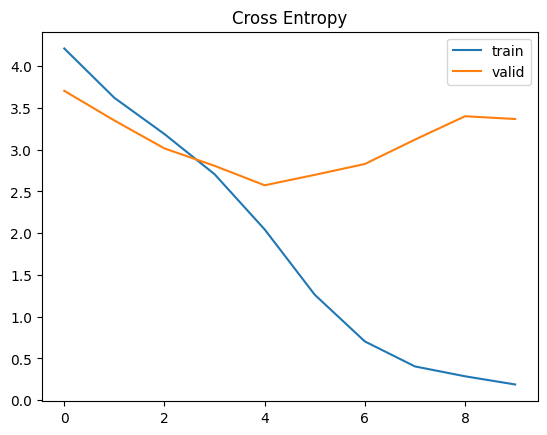

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

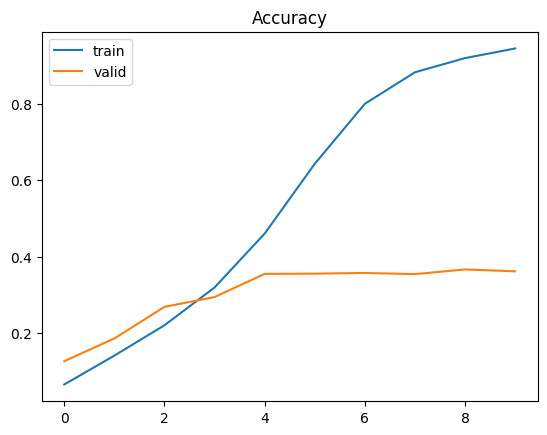

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

No es un mal resultado para este problema ya que hay pocas imágenes. Sin embargo nos hemos encontrado con un grave problema de sobreajuste. Tenemos un problema y un modelo complejos, pero no tenemos datos suficientes para entrenar nuestra red. Trataremos de solucionar esto con el data augmentation.

Antes de continuar, si nos fijamos, tenemos parámetros correspondientes al tamaño de las capas convolucionales y densas, así como de max pooling, número de capas total, configuración del dropout y del optimizador.

Conforme vamos aumentando la complejidad, hay más hiperparámetros que configurar. Cuanto mejores resultados busquemos, más tiempo tendremos que dedicar a configurar la red y entender los resultados que se obtienen de ella para nuestro problema.

<a id="section3.4"></a>
# <font color="#004D7F" size=5>3.4. Data Augmentation</font>

En este apartado vamos a volver a trabajar los conceptos de data augmentation. Aunque Keras incluye muchas funciones para el diseño de redes, en el caso del preprocesamiento de imágenes es más limitado. Como punto a favor, es que estas funciones son muy fáciles de usar y como se ha comentado antes, Keras tiene muchas herramientas para aumentar su funcionalidad, como son las funciones [Backend](https://keras.io/backend/) o el poder integrar funciones directamente de TensorFlow.

Vamos a continuar con el dataset de flores y para ello vamos a definir un nuevo `ImageDataGenerator` pero solo para el train. Esta clase la hemos visto más arriba, pero vamos a definirla un poco más en detalle, ya que se divide principalmente en dos partes:
* Primero, en el constructor definimos las operaciones o modificaciones que vamos a realizar a los datos.
* Segundo, con las funciones `flow` generamos un iterador que se va a encargar de leer los datos. Por eso los parámetros de entrada de las funciones `flow` indican donde se encuentran las imágenes, el formato de estas y el tamaño de salida. También indicamos aquí el tamaño del batch del iterador.

Con esto el iterador obtenido primero cargará el batch de datos según lo indicado en los parámetros de las funicones `flow` y luego aplicará las funciones definidas en el constructor de [`ImageDataGenerator`](https://keras.io/preprocessing/image/). Estas funciones consisten en data augmentation estocástico, es decir, cada operación que se ha indicado se aplica de forma aleatoria a las diferentes datos, en este caso imágenes, de los batches.

In [13]:
train_datagen_augmented = ImageDataGenerator(rescale=1./255, horizontal_flip = True, vertical_flip = True, rotation_range = 10)

train_iter_augmented = train_datagen_augmented.flow_from_dataframe(train_frame,
                                                                   x_col='files',
                                                                   y_col='labels',
                                                                   target_size=(100, 120),
                                                                   class_mode='categorical',
                                                                   batch_size=32,
                                                                   shuffle=True)

Found 4913 validated image filenames belonging to 102 classes.


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

# definimos el modelo lineal
model = Sequential()

# el primer bloque convolucional completo, formado de dos capas convolucionales con activación relu,
# un max pooling y un dropout.

# recordemos que en la primera capa hay que indicar el tamaño de la entrada
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(100, 120, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Antes de poder pasar de la capa convolucional a la densa, es necesario "aplanar" la salida, por eso se usa Flatten
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# finalmente creamos la capa de salida, con el tamaño de las etiquetas de nuestro problema
model.add(Dense(102, activation='softmax'))

In [15]:
sgd = SGD(learning_rate=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

history = model.fit(train_iter_augmented,
                              steps_per_epoch = train_frame.shape[0]//train_iter_augmented.batch_size,
                              epochs=10,
                              validation_data=valid_iter,
                              validation_steps= valid_frame.shape[0]//valid_iter.batch_size)

Epoch 1/10
153/153 [==============================] - 348s 2s/step - loss: 4.2505 - acc: 0.0613 - val_loss: 3.8384 - val_acc: 0.1017
Epoch 2/10
153/153 [==============================] - 386s 3s/step - loss: 3.8053 - acc: 0.1086 - val_loss: 3.6607 - val_acc: 0.1189
Epoch 3/10
153/153 [==============================] - 368s 2s/step - loss: 3.5703 - acc: 0.1446 - val_loss: 3.2031 - val_acc: 0.2071
Epoch 4/10
153/153 [==============================] - 353s 2s/step - loss: 3.3108 - acc: 0.1934 - val_loss: 3.1175 - val_acc: 0.2230
Epoch 5/10
153/153 [==============================] - 375s 2s/step - loss: 3.1127 - acc: 0.2280 - val_loss: 2.8683 - val_acc: 0.2812
Epoch 6/10
153/153 [==============================] - 357s 2s/step - loss: 2.8868 - acc: 0.2702 - val_loss: 2.8360 - val_acc: 0.2874
Epoch 7/10
153/153 [==============================] - 378s 2s/step - loss: 2.6909 - acc: 0.3120 - val_loss: 2.8376 - val_acc: 0.2947
Epoch 8/10
153/153 [==============================] - 377s 2s/step - 

In [16]:
score = model.evaluate(valid_iter, steps= valid_frame.shape[0]//valid_iter.batch_size)
print("loss en validación: {} \naccuracy en validación: {}".format(score[0],score[1]))
score = model.evaluate(test_iter, steps= test_frame.shape[0]//test_iter.batch_size)
print("loss en test: {} \naccuracy en test: {}".format(score[0],score[1]))

51/51 [==============================] - 21s 401ms/step - loss: 2.4001 - acc: 0.3768
loss en validación: 2.40010666847229 
accuracy en validación: 0.37683823704719543
51/51 [==============================] - 20s 392ms/step - loss: 2.4083 - acc: 0.3817
loss en test: 2.4083101749420166 
accuracy en test: 0.38174018263816833


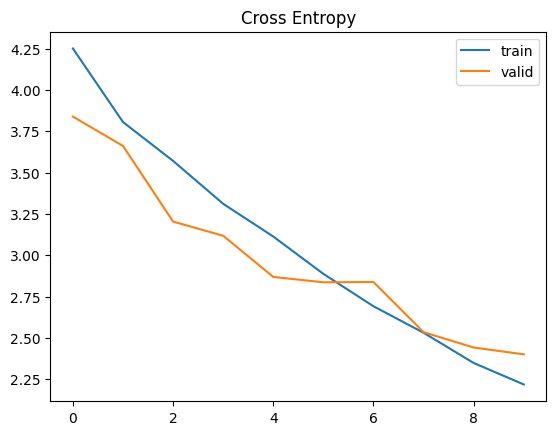

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy')
plt.show()

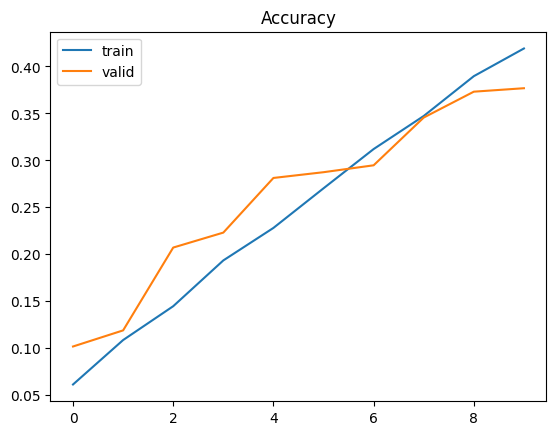

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy')
plt.show()

Hemos visto claramente la utilidad del data augmentation y lo fácil que es aplicar dichas funciones con Keras. Con esto ya hemos repasado los puntos más importantes de Keras para poder empezar a trabajar con nuestras bases de datos, diseñar y entrenar nuestras redes y evaluar su comportamiento.

---

<h3><font color="#004D7F" size=5> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicio</font></h3>

Mejorar los resultados obtenidos por la red. Actualmente solo hay 3 capas (2 convolucionales y 1 densa). Se recomienda también probar diferentes optimizadores y utilizar mas parámetros a la hora de realizar data augmentation.

In [19]:
# TODO

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>